## Ilinois Basin data preliminary analysis

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_preparation import Catalogue
from tqdm import tqdm
import os
import pickle
from clustering_module import ScipyHierarchy, EvaluateClustering

### Data analysis

In [2]:
raw_catalogue = pd.read_excel(r'../data/illinois_basin/data/DD_relocations_catalogue_20200428_regionletters_95pcnt_confidence.xlsx', sheet_name='Local_crs_metres', index_col=[0])

The 'latitude' 'longitude' are in reality relative northing/easting positions

In [3]:
reduced_catalogue = raw_catalogue[['SLB origin time', 'SLB northing (m)', 'SLB easting (m)', 'SLB depth (m)', 'SLB magnitude (Mw)']].copy()
reduced_catalogue = reduced_catalogue.rename(columns={'SLB origin time':'event_time', 'SLB northing (m)':'Latitude', 'SLB easting (m)': 'Longitude', 'SLB depth (m)': 'Depthkm', 'SLB magnitude (Mw)':'magnitude'})
reduced_catalogue.head()

,event_time,Latitude,Longitude,Depthkm,magnitude
NORSAR_ID,,,,,
2636,2012-10-07 21:42:31.324,1613.611,-1833.372,2213.762,-0.34
2647,2012-10-09 05:30:48.846,1621.536,-1820.875,2207.971,-0.54
3921,2013-09-15 23:05:32.826,1600.505,-1835.201,2194.560,0.13
2664,2012-10-10 14:34:42.771,1585.265,-1848.612,2208.276,-0.67
3911,2013-09-15 19:55:27.488,1581.912,-1842.211,2201.875,0.25


In [4]:
print(reduced_catalogue.event_time.min(), reduced_catalogue.event_time.max())

2011-12-15 00:57:20.746000 2018-07-02 00:39:13.613000


In [5]:
print(f'Latitude: {reduced_catalogue.Latitude.min()} to {reduced_catalogue.Latitude.max()}')
print(f'Longitude: {reduced_catalogue.Longitude.min()} to {reduced_catalogue.Longitude.max()}')
print(f'Depth: {reduced_catalogue.Depthkm.min()} to {reduced_catalogue.Depthkm.max()}')

Latitude: -893.064 to 2214.982
Longitude: -2252.472 to 1204.57
Depth: 1834.896 to 2271.065


In [6]:
geo_bounds = {'lat_min': -2000,
            'lat_max': 2000,
            'long_min': -2000,
            'long_max': 2000,
            'depth_min': 1500,
            'depth_max': 2500,
            'step_l': 200,
            'step_d': 50}

In [7]:
data_catalogue = Catalogue(catalogue = reduced_catalogue, geo_bounds=geo_bounds)
data_catalogue.index_cubes()

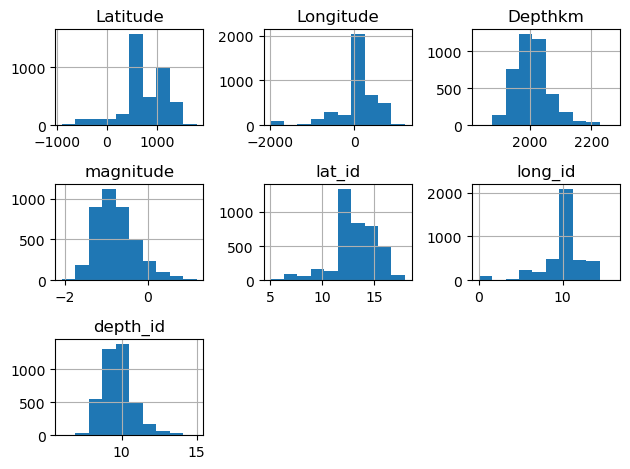

In [8]:
data_catalogue.reduced_catalogue[['Latitude', 'Longitude', 'Depthkm', 'magnitude', 'lat_id',
       'long_id', 'depth_id']].hist()
plt.tight_layout()

### Time series and distance matrix preparation

In [9]:
def index_1d(row:pd.Series, max_lat:int, max_long:int) -> int:
    #Retrun index
    return int(row['lat_id'] + max_lat * row['long_id'] + max_lat * max_long * row['depth_id'])

In [10]:
# distance_matrices = []
# time_ranges = [1, 0.5, 0.125]

# for t, time_range in enumerate(time_ranges):
#     start_date = data_catalogue.reduced_catalogue.event_time.min()
#     data_catalogue.reduced_catalogue['year'] = reduced_catalogue.apply(lambda row: row.event_time.year, axis=1)
#     data_catalogue.reduced_catalogue['month'] = reduced_catalogue.apply(lambda row: row.event_time.month, axis=1)
#     data_catalogue.reduced_catalogue['day_id'] = reduced_catalogue.apply(lambda row: int((row.event_time-start_date).days // time_range), axis=1)

#     df_density = data_catalogue.compile_dataset_days()

#     lat_max = len(data_catalogue.lat_range)
#     long_max = len(data_catalogue.long_range)

#     df_density['index_1D'] = df_density.apply(lambda row: index_1d(row, lat_max, long_max), axis=1)

#     # preallocation of results - in the output array each row corresponds to one cube, and each columt to one month
#     result = np.zeros((len(data_catalogue.lat_range)*len(data_catalogue.long_range)*len(data_catalogue.depth_range), df_density['period'].max()))

#     print(f"Time series: ")
#     for i, index in tqdm(enumerate(df_density['index_1D'].unique())):

    
#         selected_data = df_density[df_density['index_1D'] == index]

#         for ii in range(df_density['period'].max()):

#             if selected_data[selected_data['period'] == ii].empty:
#                 continue
#             else:
#                 month_data = selected_data[selected_data['period'] == ii]
#                 result[index, ii] = month_data.iloc[0, 3]

#     data_catalogue.time_series_array = result.astype('int32')

#     if distance_matrices is None:
#         distance_matrices = data_catalogue.distance_matrix()
#     else:
#         distance_matrices.append(data_catalogue.distance_matrix())
    
#     np.savetxt(f'ditance_matrix_{time_range}', distance_matrices[t])
#     np.savetxt(f'time_series_{time_range}', result.astype('int32'))

### Old plots

Plot them on the same graph

In [11]:
# plt.figure(figsize=(12,8))
# for index in (df_density['index_1D'].unique()):
#     plt.plot(time_series[index, :], alpha=0.5)

In [12]:
# X_mesh, Y_mesh = np.meshgrid(data_catalogue.long_range[:-1], data_catalogue.lat_range[:-1])
# hist, x_edges, y_edges = np.histogram2d(data_catalogue.reduced_catalogue['Longitude'], data_catalogue.reduced_catalogue['Latitude'], bins=(data_catalogue.long_range, data_catalogue.lat_range))

# plt.contourf(X_mesh, Y_mesh, np.log10(hist), cmap='jet', vmin=0, vmax=3)
# plt.colorbar()
# plt.show()

# x_range, y_range = range(len(data_catalogue.long_range)), range(len(data_catalogue.lat_range))
# X_mesh, Y_mesh = np.meshgrid(x_range[:-1], y_range[:-1])

# hist, x_edges, y_edges = np.histogram2d(df_density['long_id'], df_density['lat_id'], bins=(x_range, y_range))

# plt.contourf(X_mesh, Y_mesh, hist, cmap='jet', vmin=0)
# plt.colorbar()
# plt.show()

### Clustering evaluation

1. Start with 4 configs - 3h, 12h, 24h, 72h
2. Clustering based on DTH
3. Check the silhouette coefficient to determine the no clusters and which config is better
4. Try to retrieve information on the injections and well positions (either the website or the paper)

In [13]:
# Load distance matrices
distance_matrices = {}
keys = ['72h', '24h', '12h', '3h']
file_path = r'..\data\illinois_basin\clustering_evaluation\distance_matrix'

for i, file_name in enumerate(os.listdir(file_path)):

    with open(os.path.join(file_path, file_name), 'rb') as dm :
        distance_matrices[keys[i]] = pickle.load(dm)

In [14]:
search_params = {'threshold' : np.arange(2, 15, 1),
                 'method': ['ward', 'average'],
                 'reduce': [False]}

In [15]:
# clustering_scores = {}

# for i, key in enumerate(distance_matrices):
    
#     eval = EvaluateClustering(ScipyHierarchy, distance_matrices[key])
#     clustering_scores[key] = eval.grid_search_clustering(search_params)

In [16]:
# clustering_scores[keys[3]].sort_values(by='score_sil', ascending = False)

In [17]:
# for i, key in enumerate(clustering_scores):

#     clustering_scores[key].to_csv('clustering_scores_' + key)

In [18]:
# Load distance matrices
distance_matrices = {}
keys = ['72h', '24h', '12h', '3h']
file_path = r'..\data\illinois_basin\clustering_evaluation\distance_matrix'

for i, file_name in enumerate(os.listdir(file_path)):

    with open(os.path.join(file_path, file_name), 'rb') as dm :
        distance_matrices[keys[i]] = pickle.load(dm)

### eq-nodes time series clustering

1. Extract the time series and save in pkl
2. Save eq-nodes indices
3. Get rid of zero-nodes
4. Recompile distance matrices
5. Reevaluate clustering

In [19]:
# Load distance matrices
time_series = {}
keys = ['72h', '24h', '12h', '3h']
file_path = r'..\data\illinois_basin\clustering_evaluation\time_series'

for i, file_name in enumerate(os.listdir(file_path)):

    with open(os.path.join(file_path, file_name), 'rb') as dm :
        time_series[keys[i]] = pickle.load(dm)

In [20]:
all_nodes = np.arange(len(time_series[keys[0]]))
eq_nodes = all_nodes[np.sum(time_series[keys[0]], axis=1) > 0]

In [22]:
time_series_eq_nodes = {}

for key, time_series_array in time_series.items():
    time_series_eq_nodes[key] = time_series_array[eq_nodes]

Produce distance matrix

In [24]:
distance_matrices_eq_nodes = {}

for key, time_series_array in time_series_eq_nodes.items():

    data_catalogue.time_series_array = time_series_array
    distance_matrices_eq_nodes[key] = data_catalogue.distance_matrix()

100%|██████████| 322/322 [00:01<00:00, 226.83it/s]


Evaluate clustering

In [33]:
search_params = {'threshold' : np.arange(2, 15, 1),
                 'method': ['ward', 'average', 'single', 'complete'],
                 'reduce': [False]}

clustering_scores = {}

for i, key in enumerate(distance_matrices_eq_nodes):
    
    eval = EvaluateClustering(ScipyHierarchy, distance_matrices_eq_nodes[key])
    clustering_scores[key] = eval.grid_search_clustering(search_params)

100%|██████████| 52/52 [00:00<00:00, 201.64it/s]


In [35]:
for i, key in enumerate(clustering_scores):

    clustering_scores[key].to_csv(f'clustering_scores_eq_nodes_{key}.csv')

In [54]:
np.sum(np.sum(time_series_eq_nodes['72h'], axis = 1) > 2) / len(time_series_eq_nodes['72h'])

0.531055900621118